In [39]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from tqdm import tqdm
import numpy as np
from datasets import load_dataset
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
from scipy.sparse import csr_matrix


def plot(x,y, class_=None):
    
    if class_ is not None:
        Classes = {'scholar_province':0, 'scholar_global':1}
        label = [Classes[i] for i in class_]
        plt.scatter(x,y, c=label, cmap='Spectral', color='r')
        plt.title(f'Embedding of the training set by UMAP', fontsize=12);

    else: 
        plt.figure(figsize=(12,8))
        plt.scatter(x,y, alpha=0.7, s=0.1, color='r')
        plt.title(f'Previews Embedding of the training set by UMAP', fontsize=12); 
        
def clustering(vector, 
               cluster_model: MeanShift = MeanShift(bandwidth=0.2)):
    
    return cluster_model.fit(vector)

def calculate_centroids(data, labels):
    
    unique_labels = np.unique(labels)
    centroids = []
    for label in unique_labels:
        if label != -1:  # Exclude noise points
            points_in_cluster = data[labels == label]
            centroid = points_in_cluster.mean(axis=0)
            centroids.append(list(centroid))
            
    return np.array(centroids)
    
def visualize(data: pd.DataFrame, cluster_model): 

    xs = data.get('x').tolist()
    ys = data.get('y').tolist()
    X_umap = np.stack((xs, ys), axis=1)
    
    # Kernel Density Estimation
    kde = KernelDensity(bandwidth=0.2)
    kde.fit(X_umap)
    
    # Create a meshgrid to plot KDE result
    x_min, x_max = X_umap[:, 0].min() - 1, X_umap[:, 0].max() + 1
    y_min, y_max = X_umap[:, 1].min() - 1, X_umap[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    Z = np.exp(kde.score_samples(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    
    # Use Mean Shift to find center points from the contour
    cluster_model = cluster_model.fit(X_umap)
    cluster_list = cluster_model.labels_
    
    # Plot KDE result
    plt.figure(figsize=(12,6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues)
    plt.colorbar()
    
    # Plot center points
    plt.scatter(xs, ys, alpha=0.2, s=0.1)
    try : 
        centers = cluster_model.cluster_centers_
        
    except :
        centers = calculate_centroids(X_umap, cluster_list)
    
    plt.scatter(centers[:, 0], centers[:, 1], marker='x', c='red', s=50, edgecolors='k')
    
    plt.title(f'Kernel Density Estimation with {cluster_model.__class__.__name__} Centers')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.show() 
    
    plt.figure(figsize=(12,6))
    
    colors = [plt.cm.viridis(i / len(cluster_list)) for i in range(len(cluster_list))]
    plt.scatter(xs, ys, alpha=0.9, s=0.1, c=cluster_list)
    plt.title(f'Plot Labels')
    plt.show() 

    return cluster_model, kde, Z

In [40]:
df = pd.read_parquet('data.parquet')
df

,data_process,cluster,data_display,vector,x,y
35160,Oil Holds Above \$46 Supply Worries Linger Oil...,9,X: 13.6609 Y: 5.2557 Content: Oil Holds Above ...,"[-0.037323777, -0.023034621, -0.0003028537, 0....",13.660910,5.255730
76793,Celebration bringing fans from all over From t...,6,X: -1.4279 Y: 2.6829 Content: Celebration brin...,"[-0.051372014, -0.019107435, 0.00253632, 0.022...",-1.427852,2.682880
20342,"GOLF NOTEBOOK Singh, not Tiger, shows killer i...",8,X: 0.5902 Y: 6.272 Content: GOLF NOTEBOOK Sing...,"[0.01165124, -0.065393165, -0.0058870404, 0.00...",0.590150,6.271986
8455,Lily shuts down Red Sox The last the Red Sox h...,6,X: -1.4942 Y: 2.4827 Content: Lily shuts down ...,"[-0.06138032, -0.036379267, 0.01826619, -0.011...",-1.494172,2.482733
101056,"Citing threat, UN bolsters unit in Congo KINSH...",11,"X: 7.7438 Y: 8.0898 Content: Citing threat, UN...","[0.0843532, -0.07057545, 0.03266237, -0.014333...",7.743787,8.089776
...,...,...,...,...,...,...
49791,Twins shrug off #39;David vs. Goliath #39; NE...,6,X: -1.7094 Y: 2.4481 Content: Twins shrug off ...,"[-0.046738256, 0.02317642, 0.016340084, 0.0363...",-1.709410,2.448076
22197,"Since 9/11, Rich Arabs Again Frolic in Lebanon...",1,"X: 6.8157 Y: 7.6781 Content: Since 9/11, Rich ...","[-0.057260487, 0.04499636, -0.010496994, 0.019...",6.815698,7.678064
30296,Afghan president under fire Afghanistan #39;s ...,1,X: 7.7562 Y: 7.0691 Content: Afghan president ...,"[0.012236158, -0.011140061, -0.037222344, 0.01...",7.756220,7.069086
25115,Fighting in Baghdad kills eight Strong explosi...,11,X: 6.0887 Y: 7.9839 Content: Fighting in Baghd...,"[-0.042558823, -0.0027224298, 0.01937868, 0.01...",6.088701,7.983923


/var/folders/xf/1xvzht_s2k1_t5hs1h05rb3h0000gn/T/ipykernel_14003/3356667095.py:87: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(centers[:, 0], centers[:, 1], marker='x', c='red', s=50, edgecolors='k')


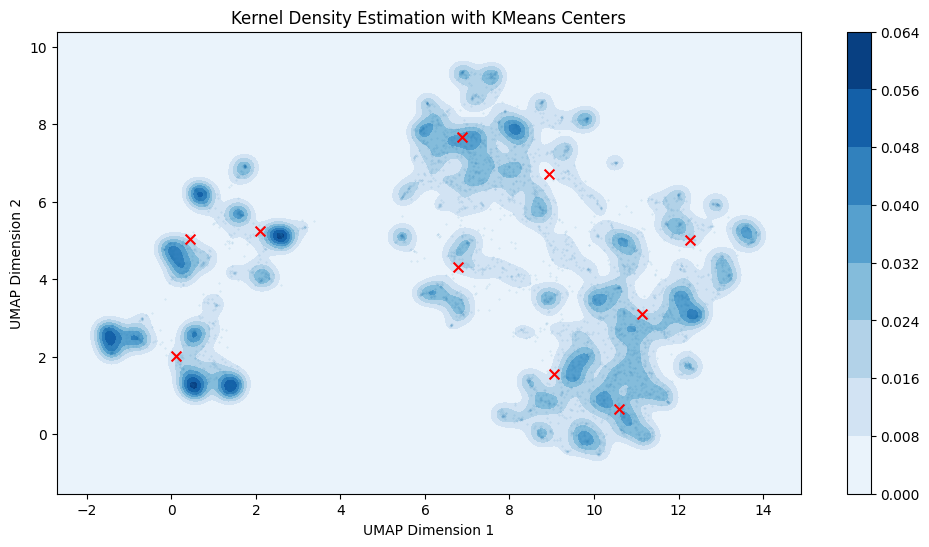

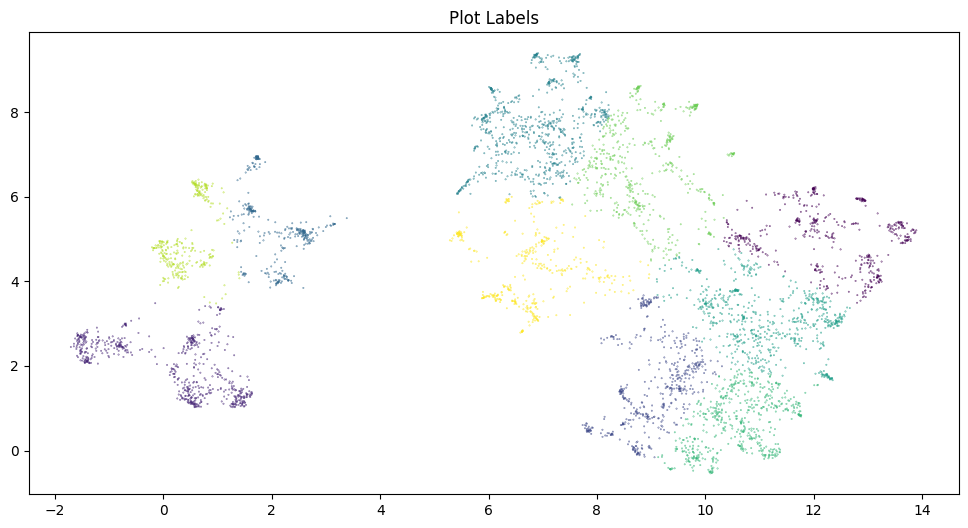

In [41]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=123, n_init="auto", )
kmeans, kde,z = visualize(df, kmeans)

In [35]:
kmeans.cluster_centers_.shape

(10, 2)

In [22]:
z.shape

(300, 300)

In [23]:
z.reshape((-1,1))

array([[1.85673874e-06],
       [2.06431658e-06],
       [2.29274788e-06],
       ...,
       [2.42278719e-08],
       [2.15350835e-08],
       [1.91055661e-08]])

array([[<Axes: title={'center': '0'}>]], dtype=object)

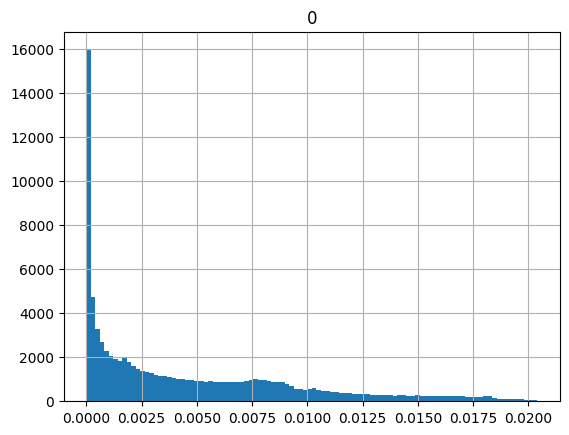

In [24]:
pd.DataFrame(z.reshape((-1,1))).hist(bins=100)

array([[<Axes: title={'center': '0'}>]], dtype=object)

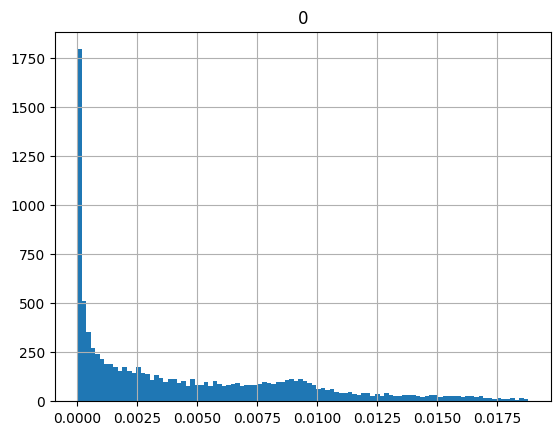

In [12]:
pd.DataFrame(z.reshape((-1,1))).hist(bins=100)

In [ ]:
def get_entropy(z):
    for i in z :

    

In [ ]:
z.reshape((1,-1)).shape

/var/folders/xf/1xvzht_s2k1_t5hs1h05rb3h0000gn/T/ipykernel_14003/3934672096.py:87: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(centers[:, 0], centers[:, 1], marker='x', c='red', s=50, edgecolors='k')


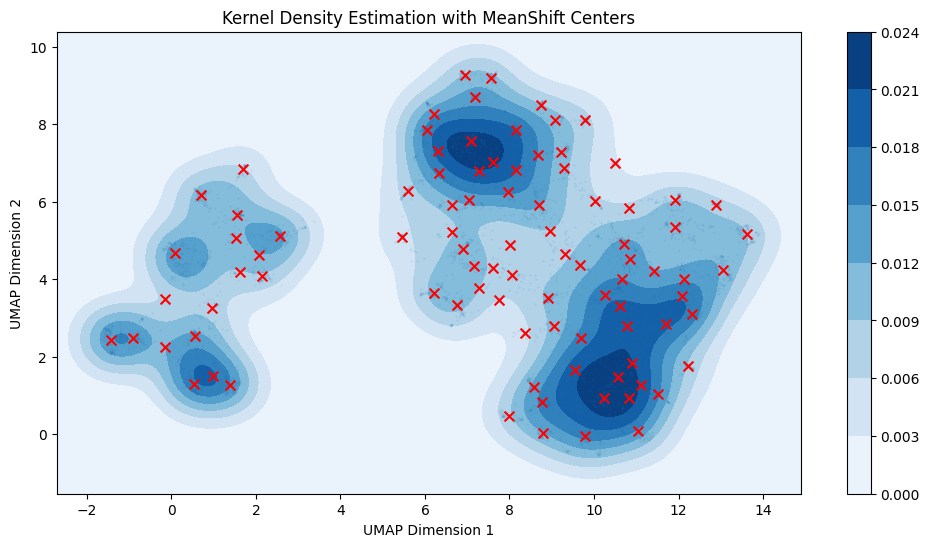

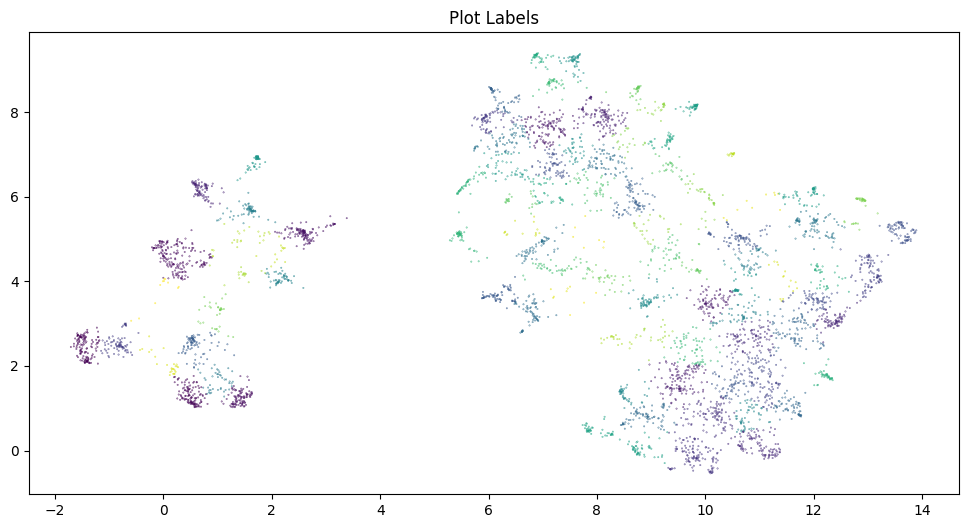

In [36]:
ms = MeanShift(bandwidth=0.4, max_iter=300)
ms = visualize(df, ms)

/var/folders/xf/1xvzht_s2k1_t5hs1h05rb3h0000gn/T/ipykernel_14003/3934672096.py:87: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(centers[:, 0], centers[:, 1], marker='x', c='red', s=50, edgecolors='k')


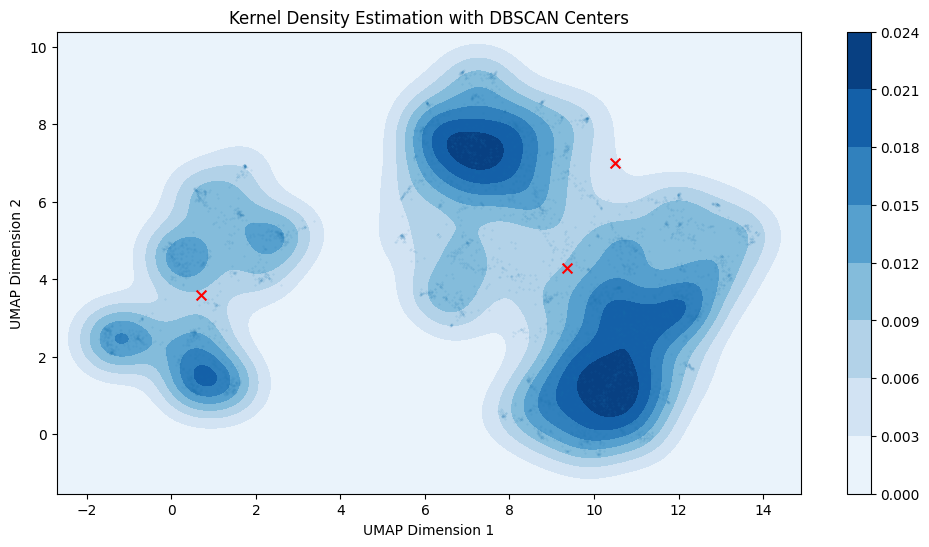

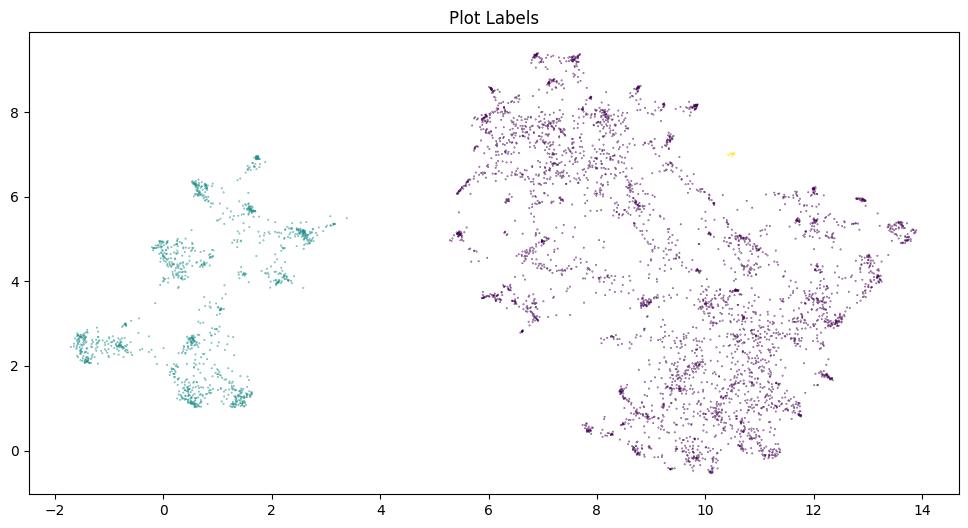

In [37]:
db = DBSCAN()
db = visualize(df, db)

/var/folders/xf/1xvzht_s2k1_t5hs1h05rb3h0000gn/T/ipykernel_14003/3934672096.py:87: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(centers[:, 0], centers[:, 1], marker='x', c='red', s=50, edgecolors='k')


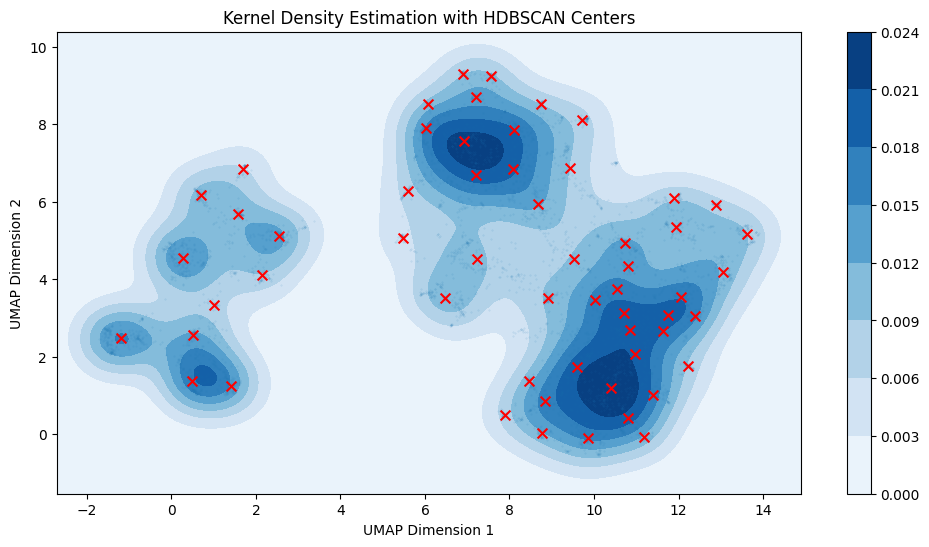

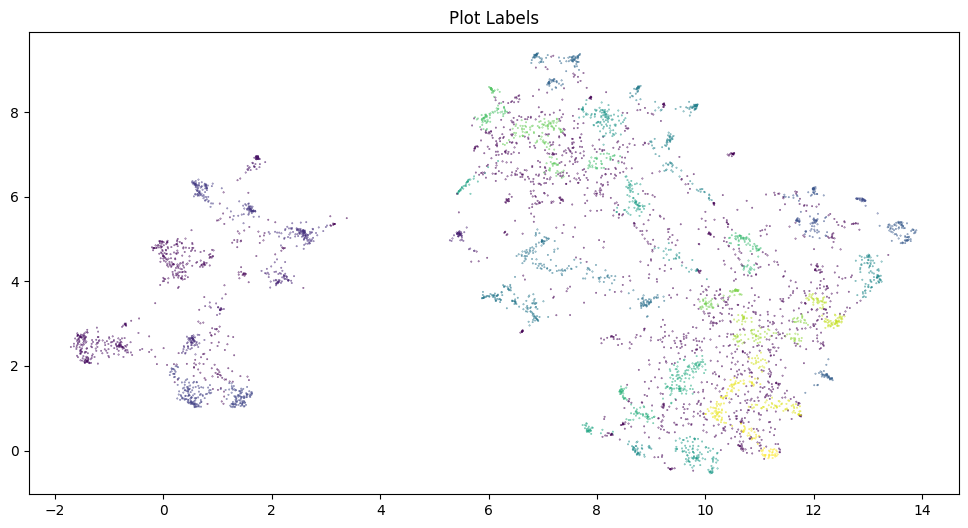

In [38]:
hbd = HDBSCAN(min_cluster_size=18)
hbd = visualize(df, hbd)

In [65]:
df['cluster'] = hbd.labels_
df

,data_process,cluster,data_display,vector,x,y
35160,Oil Holds Above \$46 Supply Worries Linger Oil...,15,X: 13.6609 Y: 5.2557 Content: Oil Holds Above ...,"[-0.037323777, -0.023034621, -0.0003028537, 0....",13.660910,5.255730
76793,Celebration bringing fans from all over From t...,1,X: -1.4279 Y: 2.6829 Content: Celebration brin...,"[-0.051372014, -0.019107435, 0.00253632, 0.022...",-1.427852,2.682880
20342,"GOLF NOTEBOOK Singh, not Tiger, shows killer i...",9,X: 0.5902 Y: 6.272 Content: GOLF NOTEBOOK Sing...,"[0.01165124, -0.065393165, -0.0058870404, 0.00...",0.590150,6.271986
8455,Lily shuts down Red Sox The last the Red Sox h...,1,X: -1.4942 Y: 2.4827 Content: Lily shuts down ...,"[-0.06138032, -0.036379267, 0.01826619, -0.011...",-1.494172,2.482733
101056,"Citing threat, UN bolsters unit in Congo KINSH...",29,"X: 7.7438 Y: 8.0898 Content: Citing threat, UN...","[0.0843532, -0.07057545, 0.03266237, -0.014333...",7.743787,8.089776
...,...,...,...,...,...,...
49791,Twins shrug off #39;David vs. Goliath #39; NE...,1,X: -1.7094 Y: 2.4481 Content: Twins shrug off ...,"[-0.046738256, 0.02317642, 0.016340084, 0.0363...",-1.709410,2.448076
22197,"Since 9/11, Rich Arabs Again Frolic in Lebanon...",43,"X: 6.8157 Y: 7.6781 Content: Since 9/11, Rich ...","[-0.057260487, 0.04499636, -0.010496994, 0.019...",6.815698,7.678064
30296,Afghan president under fire Afghanistan #39;s ...,-1,X: 7.7562 Y: 7.0691 Content: Afghan president ...,"[0.012236158, -0.011140061, -0.037222344, 0.01...",7.756220,7.069086
25115,Fighting in Baghdad kills eight Strong explosi...,40,X: 6.0887 Y: 7.9839 Content: Fighting in Baghd...,"[-0.042558823, -0.0027224298, 0.01937868, 0.01...",6.088701,7.983923


In [ ]:
select_df = df[df['cluster']==1]
documents = ' '.join(select_df['data_process'].tolist())

In [69]:
documents

'Celebration bringing fans from all over From the foot of the White Mountains to the tidal flats of Ipswich, in coffee shops and college campuses, gas stations and law firms, everywhere that Pedro, Manny, and Curt are revered, they heard the call beckoning them to the shrine of Beantown baseball. Lily shuts down Red Sox The last the Red Sox had seen of Ted Lilly, he was serving up tape-measure home runs and hitting Sox sluggers with pitches in a Blue Jay loss at Fenway Park. Yanks Go Up 2-0; Cardinals Win Opener NEW YORK - Jon Lieber took a shutout into the eighth inning and John Olerud backed him with a two-run homer in the sixth off Pedro Martinez as the Yankees beat the Red Sox 3-1 Wednesday night for a 2-0 lead in their AL championship series rematch. In the National League series opener Wednesday night, Albert Pujols homered early, Larry Walker delivered three key hits and the St... GAME DAY RECAP Saturday, August 21 But Desi Relaford #39;s ninth-inning drive with two runners on a

In [5]:
idf_topics()

NameError: name 'idf_topics' is not defined

In [6]:
cluster_summary = get_top_words_in_clusters(df)

NameError: name 'get_top_words_in_clusters' is not defined

In [ ]:
cluster_summary

In [ ]:
ct_df = pd.DataFrame(cluster_summary)

In [10]:
df.to_parquet('data.parquet')